In [1]:
import pandas as pd
import pickle
import numpy as np
import gender_analysis
import matplotlib.pyplot as plt
import os
import openpyxl
from scipy.spatial import distance
import pycountry

fontsize = 30
plt.rcParams["font.size"] = fontsize
#plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.minor.size'] = 12.5
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.minor.size'] = 12.5
plt.rcParams['hatch.linewidth'] = 0.3

pd.set_option("future.no_silent_downcasting", True)

In [2]:
# Parameters
orbis_test_size = 450
wgnd_test_size = 5000
random_state = 42
shuffle = True
include_middle_name = False
include_last_name = False
clearning_special_chars = True
min_ratio_train_to_test = 5
min_ratio_minority_to_majority = 0.2
min_name_samples = 500
arab_league = {
    "DZ", "BH", "KM", "DJ", "EG", "IQ", "JO", "KW", "LB", "LY", "MR", 
    "MA", "OM", "PS", "QA", "SA", "SO", "SD", "SY", "TN", "AE", "YE",
}

In [3]:
# Country selection
with open("./data/data_sets.pkl", 'rb') as f:
    data_by_country = pickle.load(f)

name_count_by_country = {c: (len(data_by_country[c][0]), len(data_by_country[c][1])) for c in data_by_country}

all_country_lst = [_[0] for _ in sorted(list(name_count_by_country.items()), key=lambda x: x[1], reverse=True)]
country_lst = []
n, n_ = 0, 0
arab_minority_group = set()
arab_name_samples = {}
for country in all_country_lst:
    f_name_count = len(data_by_country[country][0])
    m_name_count = len(data_by_country[country][1])
    
    if country in arab_league:
        arab_name_samples[country] = (f_name_count, m_name_count)
        
    f_test_size = orbis_test_size
    f_validation_size = orbis_test_size
    f_remaining_size = f_name_count - f_test_size - f_validation_size
    m_test_size = orbis_test_size
    m_validation_size = orbis_test_size
    m_remaining_size = m_name_count - m_test_size - m_validation_size
    
    if f_remaining_size <= m_remaining_size:
        f_train_size = f_remaining_size
        m_train_size = int(float(f_remaining_size) / min_ratio_minority_to_majority)
    else:
        f_train_size = int(float(f_remaining_size) / min_ratio_minority_to_majority)
        m_train_size = m_remaining_size
        
    #print(country, f_name_count, f_test_size + f_validation_size, m_name_count, m_test_size + m_validation_size)

    if f_train_size < f_test_size * min_ratio_train_to_test or m_train_size < m_test_size * min_ratio_train_to_test:
        if country in arab_league and f_name_count > orbis_test_size and m_name_count > orbis_test_size:
            arab_minority_group.add(country)
        continue
        
    n_ += f_name_count + m_name_count
    country_lst.append(country)

country_lst += list(arab_minority_group)

countries_with_low_auc = {'CN', 'IN', 'BD', 'KR'}
    
f_name = "./data/complementnb_best_alpha.pickle"
with open(f_name, "rb") as f:
    nb_alpha = pickle.load(f)

f_name = "./data/complementnb_prob_threshold_in_orbis.pickle"
with open(f_name, "rb") as f:
    nb_prob_threshold_orbis = pickle.load(f)

f_name = "./data/complementnb_prob_threshold_in_wgnd.pickle"
with open(f_name, "rb") as f:
    nb_prob_threshold_wgnd = pickle.load(f)

nb_prob_threshold = {}
new_country_lst = []
for country in country_lst:
    if (country not in nb_prob_threshold_orbis or country not in nb_prob_threshold_wgnd 
            or country in countries_with_low_auc):
        continue
        
    p1 = nb_prob_threshold_orbis[country]
    p2 = nb_prob_threshold_wgnd[country]
    nb_prob_threshold[country] = max(p1, p2)
    new_country_lst.append(country)
    
country_lst = list(new_country_lst)
    
f_path = ("./data/author_gender"
          + "_middle_name_" + str(include_middle_name)
          + "_last_name_" + str(include_last_name)
          + "_special_chars_" + str(clearning_special_chars)
          + ".pkl")
with open(f_path, mode="rb") as f:
    author_gender = pickle.load(f)

f_path = ("./data/author_sample_lst"
          + "_middle_name_" + str(include_middle_name)
          + "_last_name_" + str(include_last_name)
          + "_special_chars_" + str(clearning_special_chars)
          + ".pkl")

with open(f_path, mode="rb") as f:
    (author_name_corpus, author_sample_lst) = pickle.load(f)
    
num_authors_by_country = {}
for country in country_lst:

    n_f, n_m = 0, 0
    for author_id in author_sample_lst[country]:
        g = author_gender.get(author_id, -1)
        if g == 0:
            n_f += 1
        elif g == 1:
            n_m += 1

    num_authors_by_country[country] = [n_f, n_m]
    
new_country_lst_ = []
for country in country_lst:
    if (country not in nb_prob_threshold_orbis or country not in nb_prob_threshold_wgnd 
            or country in countries_with_low_auc):
        continue
        
    n_f = num_authors_by_country[country][0]
    n_m = num_authors_by_country[country][1]
    
    if n_f < 1000 or n_m < 1000:
        continue
        
    new_country_lst_.append(country)

country_lst = list(new_country_lst_)

print(len(new_country_lst), len(new_country_lst_))
print(set(new_country_lst) - set(new_country_lst_))
print(new_country_lst_)

61 58
{'PG', 'LS', 'SO'}
['RU', 'GB', 'ZA', 'IT', 'RO', 'BG', 'NO', 'CH', 'NZ', 'RS', 'CZ', 'DE', 'JO', 'IE', 'US', 'FR', 'PH', 'PL', 'LB', 'AU', 'BH', 'OM', 'DZ', 'NG', 'SE', 'ES', 'IS', 'NL', 'MD', 'EG', 'CA', 'PT', 'TR', 'KE', 'KW', 'LT', 'AT', 'DK', 'AE', 'JP', 'ZW', 'BE', 'EE', 'IR', 'ME', 'SA', 'LK', 'JM', 'GH', 'AL', 'BY', 'IL', 'MA', 'BA', 'CY', 'SY', 'IQ', 'TN']


In [4]:
f_path = ("./data/num_women_and_men_by_year"
              + "_middle_name_" + str(include_middle_name)
              + "_last_name_" + str(include_last_name)
              + "_special_chars_" + str(clearning_special_chars)
              + ".pkl")

with open(f_path, mode="rb") as f:
    num_women_and_men_by_year = pickle.load(f)

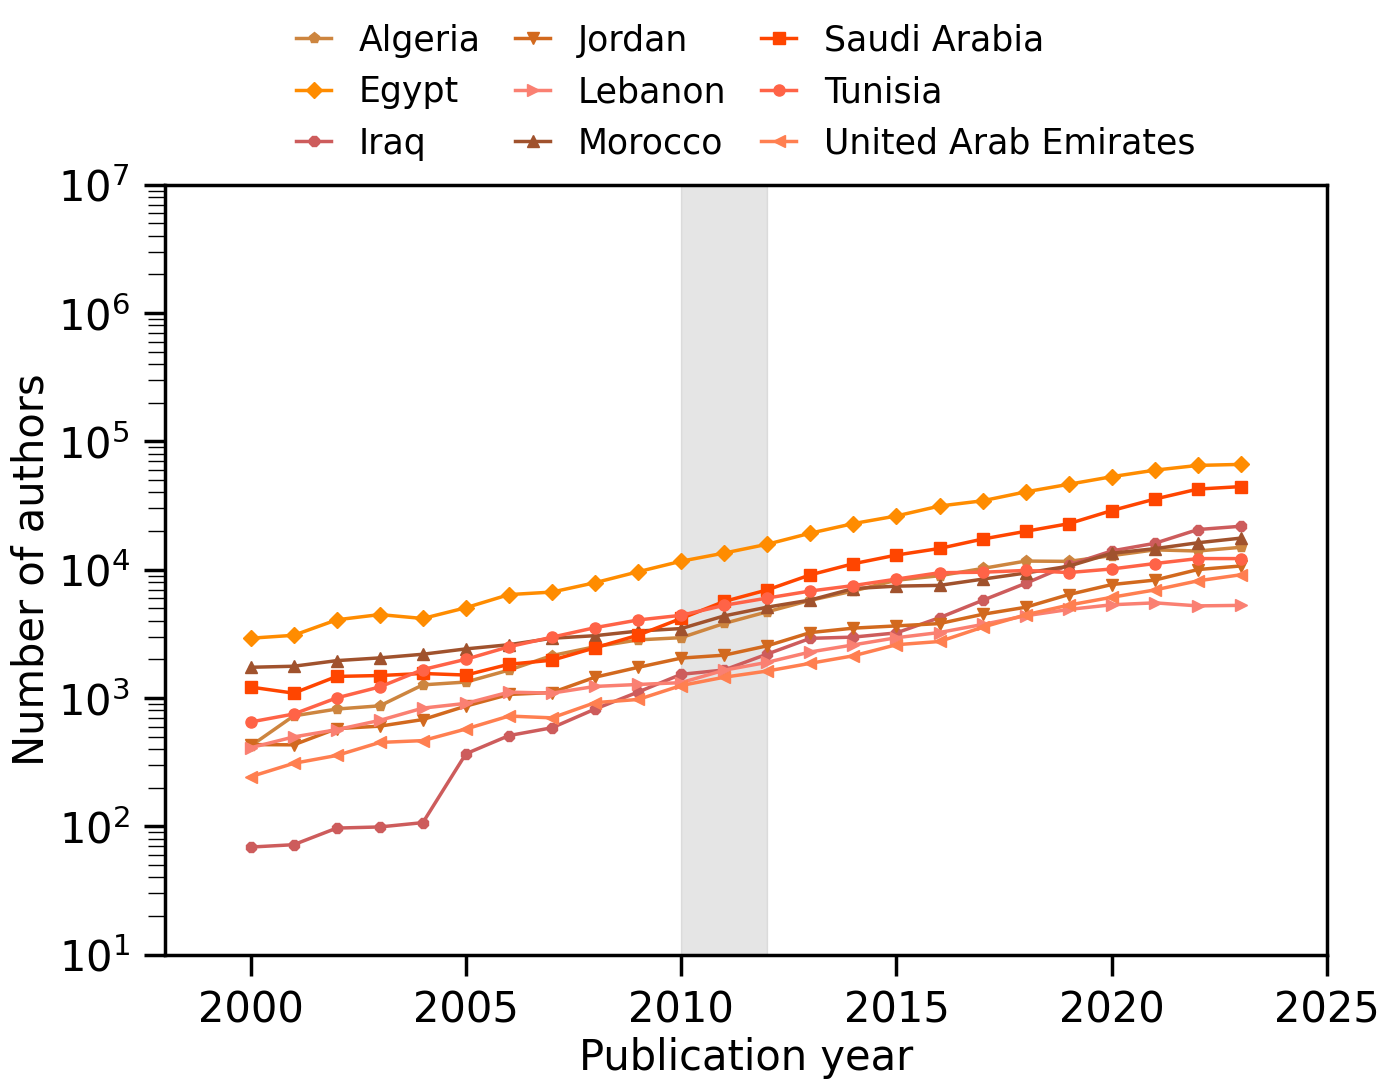

In [5]:
plt.figure(figsize=(15, 10))
color = {
    "TN": "tomato",       
    "SA": "orangered",    
    "EG": "darkorange",   
    "MA": "sienna",       
    "JO": "chocolate",    
    "AE": "coral",        
    "LB": "salmon",       
    "DZ": "peru",         
    "IQ": "indianred",    
}

marker = {
    "TN": "o",   
    "SA": "s",   
    "EG": "D",   
    "MA": "^",   
    "JO": "v",   
    "AE": "<",   
    "LB": ">",   
    "DZ": "p",   
    "IQ": "8",   
}

country_name = {
    "TN": "Tunisia",
    "SA": "Saudi Arabia",
    "EG": "Egypt",
    "MA": "Morocco",
    "JO": "Jordan",
    "AE": "United Arab Emirates",
    "LB": "Lebanon",
    "DZ": "Algeria",
    "IQ": "Iraq",
}

y_s, y_e = 2000, 2023
for country in ["DZ", "EG", "IQ", "JO", "LB", "MA", "SA", "TN", "AE"]:
    x = range(y_s, y_e+1) 
    y = [float(num_women_and_men_by_year[country][y_][0]+num_women_and_men_by_year[country][y_][1]) for y_ in range(y_s, y_e+1)]
    plt.plot(x, y, color=color[country], label=country_name[country], linewidth=2.5, linestyle="solid", marker=marker[country], markersize=8)
plt.axvspan(2010, 2012, color='gray', alpha=0.2)
plt.xticks([2000 + 5*i for i in range(0, 6)])
plt.xlim(1998, 2025)
plt.xlabel("Publication year")
plt.ylabel("Number of authors")
plt.yscale('log')
#plt.yticks([0.1*i for i in range(0, 7)])
plt.ylim(pow(10, 1), pow(10, 7))
plt.tick_params(axis='x', pad=10)
plt.tick_params(axis='y', pad=10)
#plt.subplots_adjust(left=0.25, right=0.95, bottom=0.25, top=0.95)
#plt.tight_layout()
plt.legend(frameon=False, fontsize=25, handlelength=1.0, ncol=3, columnspacing=1.0, loc='upper center', bbox_to_anchor=(0.5, 1.25))
path = "./figs/fig1_a.pdf"
plt.savefig(path, bbox_inches='tight')

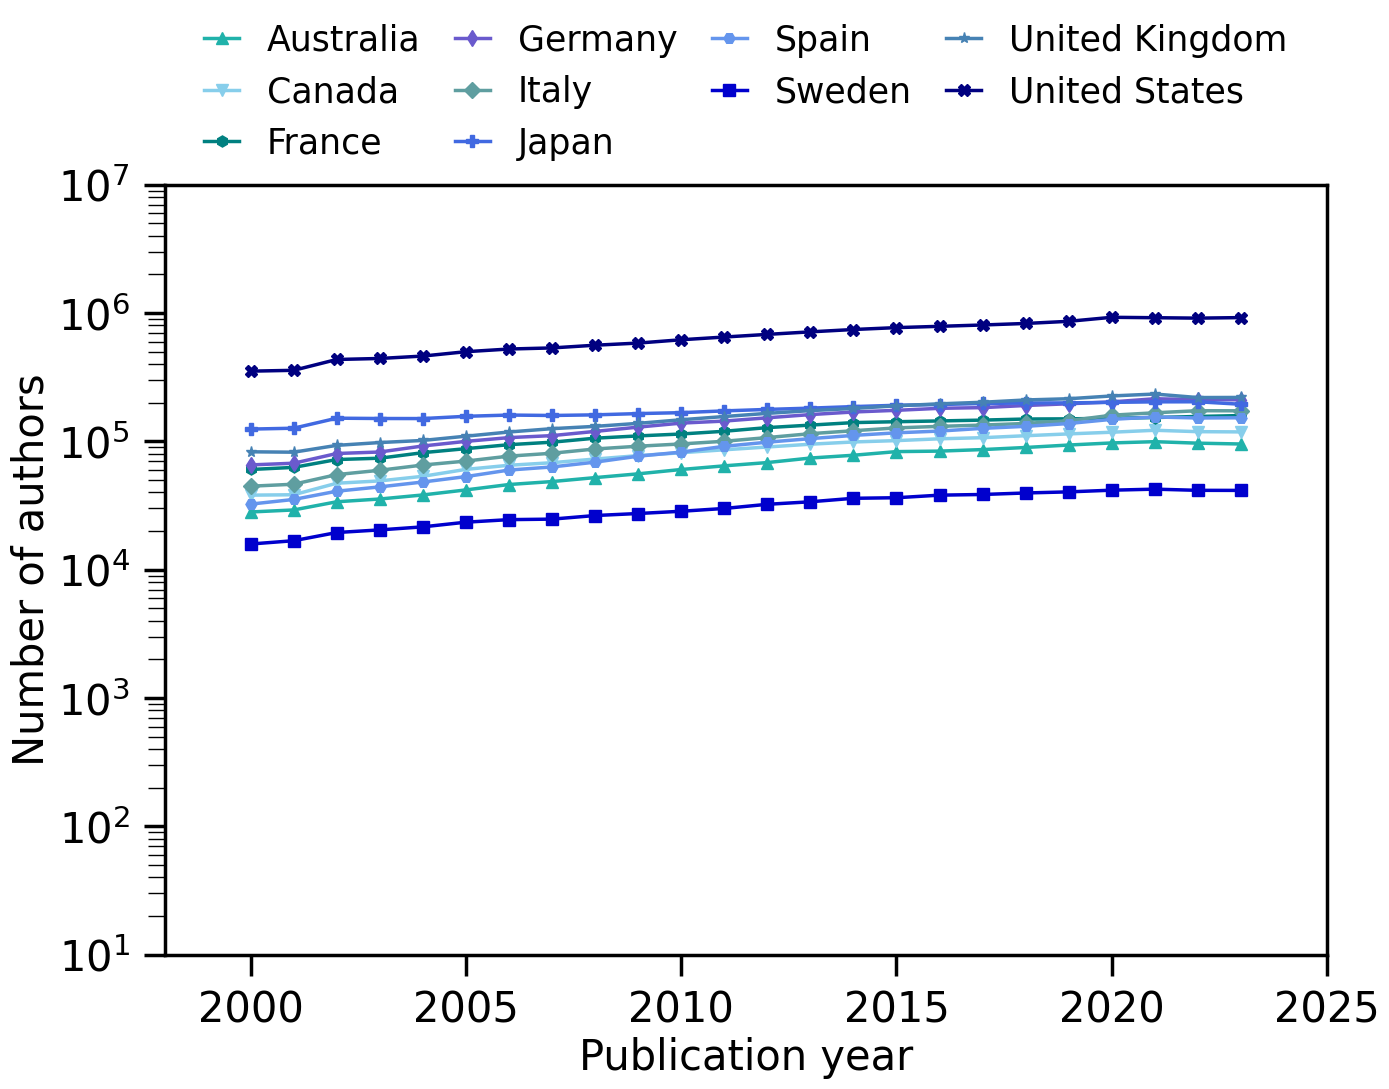

In [6]:
plt.figure(figsize=(15, 10))
color = {
    "JP": "royalblue",        
    "US": "navy",             
    "GB": "steelblue",        
    "FR": "teal",             
    "DE": "slateblue",        
    "ES": "cornflowerblue",   
    "IT": "cadetblue",        
    "CA": "skyblue",          
    "AU": "lightseagreen",    
    "SE": "mediumblue",       
}

marker = {
    "JP": "P",   
    "US": "X",   
    "GB": "*",   
    "FR": "h",   
    "ES": "H",   
    "DE": "d",   
    "IT": "D",   
    "CA": "v",   
    "AU": "^",  
    "SE": "s",   
}

country_name = {
    "JP": "Japan",
    "US": "United States",
    "GB": "United Kingdom",
    "FR": "France",
    "DE": "Germany",
    "ES": "Spain",
    "IT": "Italy",
    "CA": "Canada",
    "AU": "Australia",
    "SE": "Sweden",
}

y_s, y_e = 2000, 2023
for country in ["AU", "CA", "FR", "DE", "IT", "JP", "ES", "SE", "GB", "US"]:
    x = range(y_s, y_e+1) 
    y = [float(num_women_and_men_by_year[country][y_][0]+num_women_and_men_by_year[country][y_][1]) for y_ in range(y_s, y_e+1)]
    plt.plot(x, y, color=color[country], label=country_name[country], linewidth=2.5, linestyle="solid", marker=marker[country], markersize=8)
plt.xticks([2000 + 5*i for i in range(0, 6)])
plt.xlim(1998, 2025)
plt.xlabel("Publication year")
plt.ylabel("Number of authors")
#plt.yticks([0.1*i for i in range(0, 7)])
#plt.ylim(0, 0.6)
plt.yscale('log')
plt.ylim(pow(10, 1), pow(10, 7))
plt.tick_params(axis='x', pad=10)
plt.tick_params(axis='y', pad=10)
#plt.subplots_adjust(left=0.25, right=0.95, bottom=0.25, top=0.95)
#plt.tight_layout()
plt.legend(frameon=False, fontsize=25, handlelength=1.0, ncol=4, columnspacing=1.0, loc='upper center', bbox_to_anchor=(0.5, 1.25))
path = "./figs/fig1_b.pdf"
plt.savefig(path, bbox_inches='tight')

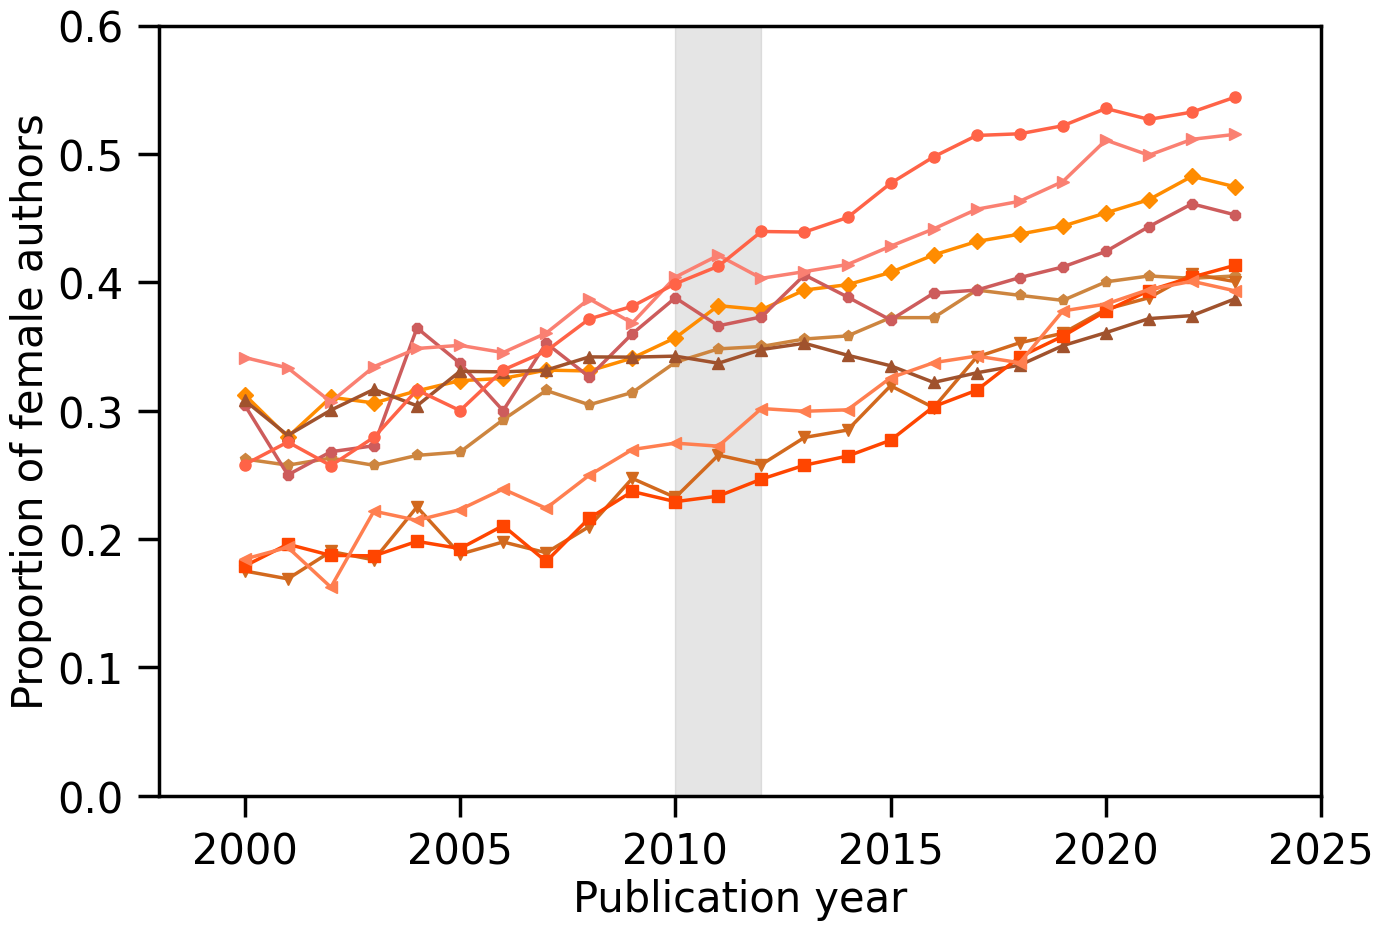

In [7]:
plt.figure(figsize=(15, 10))
color = {
    "TN": "tomato",       
    "SA": "orangered",    
    "EG": "darkorange",   
    "MA": "sienna",       
    "JO": "chocolate",    
    "AE": "coral",        
    "LB": "salmon",       
    "DZ": "peru",         
    "IQ": "indianred",    
}

marker = {
    "TN": "o",   
    "SA": "s",   
    "EG": "D",   
    "MA": "^",   
    "JO": "v",   
    "AE": "<",   
    "LB": ">",   
    "DZ": "p",   
    "IQ": "8",   
}

country_name = {
    "TN": "Tunisia",
    "SA": "Saudi Arabia",
    "EG": "Egypt",
    "MA": "Morocco",
    "JO": "Jordan",
    "AE": "United Arab Emirates",
    "LB": "Lebanon",
    "DZ": "Algeria",
    "IQ": "Iraq",
}

y_s, y_e = 2000, 2023
for country in ["DZ", "EG", "IQ", "JO", "LB", "MA", "SA", "TN", "AE"]:
    x = range(y_s, y_e+1) 
    y = [float(num_women_and_men_by_year[country][y_][0])/(num_women_and_men_by_year[country][y_][0]+num_women_and_men_by_year[country][y_][1]) for y_ in range(y_s, y_e+1)]
    plt.plot(x, y, color=color[country], label=country_name[country], linewidth=2.5, linestyle="solid", marker=marker[country], markersize=8)
plt.axvspan(2010, 2012, color='gray', alpha=0.2)
plt.xticks([2000 + 5*i for i in range(0, 6)])
plt.xlim(1998, 2025)
plt.xlabel("Publication year")
plt.ylabel("Proportion of female authors")
plt.yticks([0.1*i for i in range(0, 7)])
plt.ylim(0, 0.6)
plt.tick_params(axis='x', pad=10)
plt.tick_params(axis='y', pad=10)
#plt.subplots_adjust(left=0.25, right=0.95, bottom=0.25, top=0.95)
#plt.tight_layout()
#plt.legend(loc="lower left", frameon=False, fontsize=25, handlelength=1.0, ncol=3, columnspacing=1.0)
path = "./figs/fig1_c.pdf"
plt.savefig(path, bbox_inches='tight')

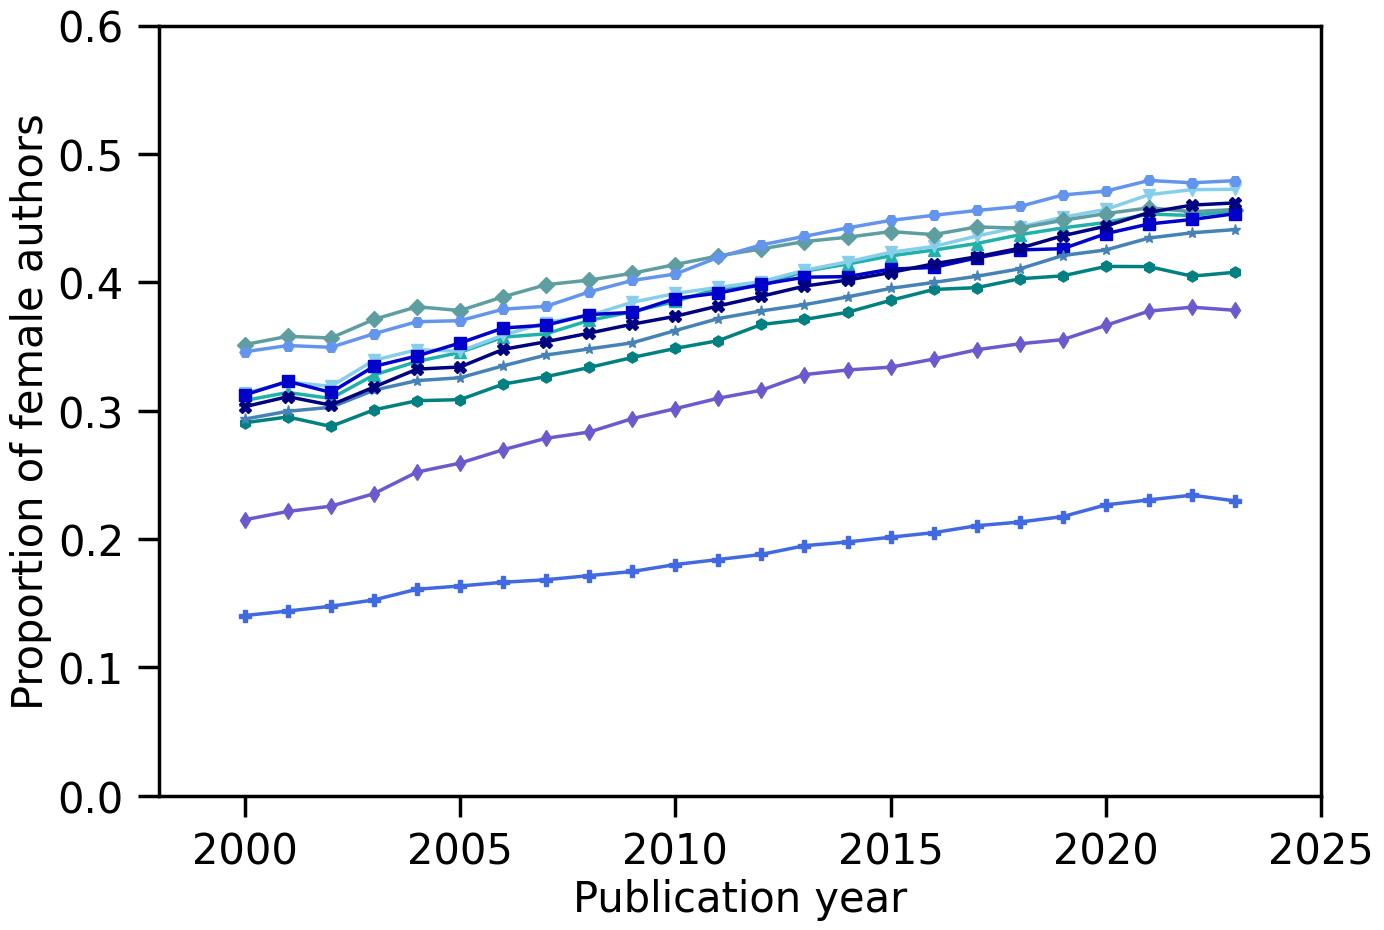

In [8]:
plt.figure(figsize=(15, 10))
color = {
    "JP": "royalblue",        
    "US": "navy",             
    "GB": "steelblue",        
    "FR": "teal",             
    "DE": "slateblue",        
    "ES": "cornflowerblue",   
    "IT": "cadetblue",        
    "CA": "skyblue",          
    "AU": "lightseagreen",    
    "SE": "mediumblue",       
}

marker = {
    "JP": "P",   
    "US": "X",   
    "GB": "*",   
    "FR": "h",   
    "ES": "H",   
    "DE": "d",   
    "IT": "D",   
    "CA": "v",   
    "AU": "^",   
    "SE": "s",   
}

country_name = {
    "JP": "Japan",
    "US": "United States",
    "GB": "United Kingdom",
    "FR": "France",
    "DE": "Germany",
    "ES": "Spain",
    "IT": "Italy",
    "CA": "Canada",
    "AU": "Australia",
    "SE": "Sweden",
}

y_s, y_e = 2000, 2023
for country in ["AU", "CA", "FR", "DE", "IT", "JP", "ES", "SE", "GB", "US"]:
    x = range(y_s, y_e+1) 
    y = [float(num_women_and_men_by_year[country][y_][0])/(num_women_and_men_by_year[country][y_][0]+num_women_and_men_by_year[country][y_][1]) for y_ in range(y_s, y_e+1)]
    plt.plot(x, y, color=color[country], label=country_name[country], linewidth=2.5, linestyle="solid", marker=marker[country], markersize=8)
plt.xticks([2000 + 5*i for i in range(0, 6)])
plt.xlim(1998, 2025)
plt.xlabel("Publication year")
plt.ylabel("Proportion of female authors")
plt.yticks([0.1*i for i in range(0, 7)])
plt.ylim(0, 0.6)
plt.tick_params(axis='x', pad=10)
plt.tick_params(axis='y', pad=10)
#plt.subplots_adjust(left=0.25, right=0.95, bottom=0.25, top=0.95)
#plt.tight_layout()
#plt.legend(loc="upper left", frameon=False, fontsize=25, handlelength=1.0, ncol=3, columnspacing=1.0)
path = "./figs/fig1_d.pdf"
plt.savefig(path, bbox_inches='tight')

In [9]:
f_path = ("./data/productive_people_pyramid"
              + "_middle_name_" + str(include_middle_name)
              + "_last_name_" + str(include_last_name)
              + "_special_chars_" + str(clearning_special_chars)
              + ".pkl")
with open(f_path, mode="rb") as f:
    productive_people_pyramid = pickle.load(f)
    
main_country_lst = ["DZ", "EG", "IQ", "JO", "LB", "MA", "SA", "TN", "AE"] + ["AU", "CA", "FR", "DE", "IT", "JP", "ES", "SE", "GB", "US"]

country_name = {
    "TN": "Tunisia",
    "SA": "Saudi Arabia",
    "EG": "Egypt",
    "MA": "Morocco",
    "JO": "Jordan",
    "AE": "United Arab Emirates",
    "LB": "Lebanon",
    "DZ": "Algeria",
    "IQ": "Iraq",
    "JP": "Japan",
    "US": "United States",
    "GB": "United Kingdom",
    "FR": "France",
    "DE": "Germany",
    "ES": "Spain",
    "IT": "Italy",
    "CA": "Canada",
    "AU": "Australia",
    "SE": "Sweden",
}

base_year = 2023
target_year = 2100

fig, ax = plt.subplots(figsize=(25, 15))
height = 1.0
left = []
for i in range(0, len(main_country_lst)):
    country = main_country_lst[i]
    (female_count, male_count, female_prob, male_prob, female_newcomer_count, male_newcomer_count) = productive_people_pyramid[(country, base_year, target_year)]
    all_n = np.sum(list(female_count[base_year].values())) + np.sum(list(male_count[base_year].values()))
    if i == 0:
        plt.bar([3*i], [float(np.sum(list(female_newcomer_count.values()))) / all_n], align="center", color="darkgreen", width=height, edgecolor='black', linewidth=3, label='Female')
        plt.bar([3*i], [float(np.sum(list(male_newcomer_count.values()))) / all_n], align="center", color="orange", width=height, edgecolor='black', linewidth=3, label='Male', bottom=[float(np.sum(list(female_newcomer_count.values()))) / all_n])
        left.append(3*i)
    else:
        plt.bar([3*i], [float(np.sum(list(female_newcomer_count.values()))) / all_n], align="center", color="darkgreen", width=height, edgecolor='black', linewidth=3)
        plt.bar([3*i], [float(np.sum(list(male_newcomer_count.values()))) / all_n], align="center", color="orange", width=height, edgecolor='black', linewidth=3, bottom=[float(np.sum(list(female_newcomer_count.values()))) / all_n])
        left.append(3*i)
    
    female_ratio = float(np.sum(list(female_newcomer_count.values()))) / (np.sum(list(female_newcomer_count.values())) + np.sum(list(male_newcomer_count.values())))
    ratio_text = f"{female_ratio * 100:.1f}%"

    plt.text(3*i, float(np.sum(list(female_newcomer_count.values()))) / all_n + float(np.sum(list(male_newcomer_count.values()))) / all_n + 0.005, ratio_text,
             ha='center', va='bottom', fontsize=23, color='darkgreen', weight='bold')

labels = [country_name[country] for country in main_country_lst]
xmin, xmax = min(left) - 2.5*height, max(left) + 2*height
#ymin, ymax = 0, 20
plt.xticks(left, labels, rotation=90)
plt.xlim(xmin, xmax)
plt.ylabel("Researcher inflow (2023)")
plt.yticks([0.05*i for i in range(0, 5)])
plt.ylim(0, 0.2)
plt.tick_params(axis='x', pad=10)
plt.tick_params(axis='y', pad=10)
#plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.95)
plt.tight_layout()
plt.legend(loc="upper right", frameon=False, fontsize=fontsize, handlelength=1.0, columnspacing=1.0)
path = "./figs/fig_3.pdf"
plt.savefig(path, bbox_inches='tight')
plt.clf()
plt.close()

In [10]:
def calc_inflow_ratio_and_gender_gap_in_career_continuity(productive_people_pyramid, country, base_year, target_year):
    
    (female_count, male_count, female_prob, male_prob,
     female_newcomer_count, male_newcomer_count) = productive_people_pyramid[(country, base_year, target_year)]

    total_active = np.sum(list(female_count[base_year].values())) + np.sum(list(male_count[base_year].values()))
    total_female = np.sum(list(female_count[base_year].values()))
    total_male = np.sum(list(male_count[base_year].values()))
    inflow_ratio = float(np.sum(list(female_newcomer_count.values())) + np.sum(list(male_newcomer_count.values()))) / total_active
    
    car_mat_f = float(np.sum([k * female_count[base_year][k] for k in female_count[base_year]])) / total_female
    car_mat_m = float(np.sum([k * male_count[base_year][k] for k in male_count[base_year]])) / total_male
    car_mat_gender_gap = float(car_mat_f - car_mat_m) / car_mat_m
    
    return inflow_ratio, car_mat_gender_gap

In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

arab_countries = {'SA', 'TN', 'EG', 'MA', 'JO', 'AE', 'LB', 'IQ', 'DZ'}
reference_countries = {'US', 'GB', 'JP', 'CA', 'ES', 'IT', 'FR', 'DE', 'AU', 'SE'}

f_path = ("./data/productive_people_pyramid"
              + "_middle_name_" + str(include_middle_name)
              + "_last_name_" + str(include_last_name)
              + "_special_chars_" + str(clearning_special_chars)
              + ".pkl")
with open(f_path, mode="rb") as f:
    productive_people_pyramid = pickle.load(f)

fig, ax = plt.subplots(figsize=(25, 15))
x, y, x_, y_, colors, markers = [], [], [], [], [], []
texts = []

for i in range(len(country_lst)):
    country = country_lst[i]
    
    base_year, target_year = 2023, 2100
    inflow_ratio, car_mat_gender_gap = calc_inflow_ratio_and_gender_gap_in_career_continuity(productive_people_pyramid, country, base_year, target_year)
    x.append(car_mat_gender_gap)
    y.append(inflow_ratio)
    
    base_year, target_year = 2010, 2100
    inflow_ratio_, car_mat_gender_gap_ = calc_inflow_ratio_and_gender_gap_in_career_continuity(productive_people_pyramid, country, base_year, target_year)
    x_.append(car_mat_gender_gap_)
    y_.append(inflow_ratio_)
    
    dx = (x[i] - x_[i])
    dy = (y[i] - y_[i])
    #print(country, x[i], y[i], x_[i], y_[i], dx, dy)
    
    if country in arab_countries:
        colors.append("forestgreen")
        markers.append("o")
    elif country in reference_countries:
        colors.append("royalblue")
        markers.append("s")
    else:
        colors.append("gray")
        markers.append("p")

label = {
    "o": "Arab countries",
    "s": "Reference countries",
    "p": "Others",
}
label_flag = {
    "o": 0,
    "s": 0,
    "p": 0,
}

for i in range(len(x)):
    if markers[i] != "p":
        continue
    if label_flag[markers[i]] == 0:
        plt.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', label=label[markers[i]],
                    alpha=0.3)
        label_flag[markers[i]] = 1
    else:
        plt.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', alpha=0.3)
        
for i in range(len(x)):
    if markers[i] != "o":
        continue
    if label_flag[markers[i]] == 0:
        plt.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', label=label[markers[i]])
        label_flag[markers[i]] = 1
    else:
        plt.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black')
    
    dx = (x[i] - x_[i])
    dy = (y[i] - y_[i])
    plt.arrow(x_[i], y_[i], 
              dx, dy,
              head_width=0.006,       
              head_length=0.003,      
              fc='darkgray', ec='darkgray',   
              linewidth=0.6,          
              length_includes_head=True
              )
    
for i in range(len(x)):
    if markers[i] != "s":
        continue
    if label_flag[markers[i]] == 0:
        plt.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', label=label[markers[i]])
        label_flag[markers[i]] = 1
    else:
        plt.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black')
    
    dx = (x[i] - x_[i])
    dy = (y[i] - y_[i])
    plt.arrow(x_[i], y_[i], 
              dx, dy,
              head_width=0.006,       
              head_length=0.003,      
              fc='darkgray', ec='darkgray',   
              linewidth=0.6,          
              length_includes_head=True
              )
    
print("Gender gap in cumulative productivity", max(x), min(x))
print("Researcher inflow", max(y), min(y))

plt.axhline(y=np.median(y), linestyle='--', color='gray', linewidth=1)
plt.axvline(x=np.median(x), linestyle='--', color='gray', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
label_order = ['Arab countries', 'Reference countries', 'Others']
handles_dict = dict(zip(labels, handles))
ordered_handles = [handles_dict[label] for label in label_order if label in handles_dict]

ax.legend(ordered_handles, label_order, loc="upper right", frameon=False,
          fontsize=fontsize, handlelength=1.0, columnspacing=1.0)

plt.xlim(-0.5, 0)
plt.ylim(0, 0.25)
plt.xlabel("Gender gap in cumulative productivity (2023)", fontsize=30)
plt.ylabel("Researcher inflow (2023)", fontsize=30)
#plt.legend(loc="upper right", frameon=False, fontsize=fontsize, handlelength=1.0, columnspacing=1.0)
plt.tick_params(axis='x', pad=10)
plt.tick_params(axis='y', pad=10)

path = "./figs/fig_5.pdf"
plt.savefig(path, bbox_inches='tight')
plt.clf()
plt.close()

Gender gap in cumulative productivity -0.04911901835109316 -0.4670658426278912
Researcher inflow 0.15309246785058175 0.04244552024905029


In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

arab_countries = {'SA', 'TN', 'EG', 'MA', 'JO', 'AE', 'LB', 'IQ', 'DZ'}
reference_countries = {'US', 'GB', 'JP', 'CA', 'ES', 'IT', 'FR', 'DE', 'AU', 'SE'}

f_path = ("./data/productive_people_pyramid"
              + "_middle_name_" + str(include_middle_name)
              + "_last_name_" + str(include_last_name)
              + "_special_chars_" + str(clearning_special_chars)
              + ".pkl")
with open(f_path, mode="rb") as f:
    productive_people_pyramid = pickle.load(f)

fig, ax = plt.subplots(figsize=(25, 15))
x, y, x_, y_, colors, markers = [], [], [], [], [], []

for i in range(len(country_lst)):
    country = country_lst[i]
    
    base_year, target_year = 2023, 2100
    inflow_ratio, car_mat_gender_gap = calc_inflow_ratio_and_gender_gap_in_career_continuity(productive_people_pyramid, country, base_year, target_year)
    x.append(car_mat_gender_gap)
    y.append(inflow_ratio)
    
    base_year, target_year = 2010, 2100
    inflow_ratio_, car_mat_gender_gap_ = calc_inflow_ratio_and_gender_gap_in_career_continuity(productive_people_pyramid, country, base_year, target_year)
    x_.append(car_mat_gender_gap_)
    y_.append(inflow_ratio_)
    
    if country in arab_countries:
        colors.append("forestgreen")
        markers.append("o")
    elif country in reference_countries:
        colors.append("royalblue")
        markers.append("s")
    else:
        colors.append("gray")
        markers.append("p")

label = {
    "o": "Arab countries",
    "s": "Reference countries",
    "p": "Others",
}
label_flag = {
    "o": 0,
    "s": 0,
    "p": 0,
}

for i in range(len(x)):
    if markers[i] == "p":
        if label_flag[markers[i]] == 0:
            ax.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', label=label[markers[i]],
                        alpha=0.3)
            label_flag[markers[i]] = 1
        else:
            ax.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', alpha=0.3)
        
for i in range(len(x)):
    if markers[i] == "o":
        if label_flag[markers[i]] == 0:
            ax.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', label=label[markers[i]])
            label_flag[markers[i]] = 1
        else:
            ax.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black')
        
        dx = (x[i] - x_[i])
        dy = (y[i] - y_[i])
        ax.arrow(x_[i], y_[i],
                  dx, dy,
                  head_width=0.006,       
                  head_length=0.003,      
                  fc='darkgray', ec='darkgray',   
                  linewidth=0.6,          
                  length_includes_head=True
                  )

for i in range(len(x)):
    if markers[i] == "s":
        if label_flag[markers[i]] == 0:
            ax.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black', label=label[markers[i]])
            label_flag[markers[i]] = 1
        else:
            ax.scatter(x[i], y[i], marker=markers[i], color=colors[i], s=200, edgecolors='black')
        
        dx = (x[i] - x_[i])
        dy = (y[i] - y_[i])
        ax.arrow(x_[i], y_[i],
                  dx, dy,
                  head_width=0.006,       
                  head_length=0.003,      
                  fc='darkgray', ec='darkgray',   
                  linewidth=0.6,          
                  length_includes_head=True
                  )
    
print("Gender gap in cumulative productivity", max(x), min(x))
print("Researcher inflow", max(y), min(y))

texts = []
for i in range(len(country_lst)):
    if markers[i] == "o" or markers[i] == "s":
        text_offset_x = 0.002
        text_offset_y = 0.004 
        
        txt = ax.text(x[i] + text_offset_x, y[i] + text_offset_y, country_lst[i],
                      fontsize=25, color=colors[i], ha='left', va='bottom')
        texts.append(txt)

adjust_text(
    texts,
    ax=ax, 
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), 
    expand_points=(1.5, 1.5),  
    expand_text=(1.3, 1.3),    
    force_text=0.5,            
    force_points=0.3,
)

ax.axhline(y=np.median(y), linestyle='--', color='gray', linewidth=1)
ax.axvline(x=np.median(x), linestyle='--', color='gray', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
label_order = ['Arab countries', 'Reference countries', 'Others']
handles_dict = dict(zip(labels, handles))
ordered_handles = [handles_dict[label] for label in label_order if label in handles_dict]

ax.legend(ordered_handles, label_order, loc="upper right", frameon=False,
          fontsize=fontsize, handlelength=1.0, columnspacing=1.0)

ax.set_xlim(-0.5, 0)
ax.set_ylim(0, 0.25)
ax.set_xlabel("Gender gap in cumulative productivity (2023)", fontsize=30)
ax.set_ylabel("Researcher inflow (2023)", fontsize=30)
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

path = "./figs/fig_5_with_country_codes.pdf"
plt.savefig(path, bbox_inches='tight')
plt.clf()
plt.close()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


Gender gap in cumulative productivity -0.04911901835109316 -0.4670658426278912
Researcher inflow 0.15309246785058175 0.04244552024905029


In [14]:
def plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n, max_productivity=100):
    
    fontsize = 30
    plt.rcParams["font.size"] = fontsize
    
    fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
    
    # Female
    y, x = [], []
    for n in range(1, max_productivity+1):
        if female_count.get(n, 0) > 0:
            y.append(n)
            x.append(female_count.get(n, 0))
        else:
            y.append(n)
            x.append(0.1)
    ax[0].barh(y, x, color='darkgreen', height=0.5, label='Female', log=True)
    ax[0].yaxis.tick_right()
    ax[0].set_yticks(np.array(range(0, max_productivity + 1, 10)))
    ax[1].set_yticklabels([])
    ax[0].set_xlim([max_n, 1])
    ax[0].set_xlabel('Number of authors')
    ax[0].set_title('Female')
    
    # Male
    y, x = [], []
    for n in range(1, max_productivity+1):
        if female_count.get(n, 0) > 0:
            y.append(n)
            x.append(male_count.get(n, 0))
        else:
            y.append(n)
            x.append(0.1)
    ax[1].barh(y, x,
               color='orange', height=0.5, label='Male', log=True)
    ax[1].set_yticks(np.array(range(0, max_productivity + 1, 10)))
    ax[1].set_xlim([1, max_n])
    ax[1].set_title('Male')
    
    fig.text(0.51, 0.5, 'Cumulative productivity', va='center', ha='center', 
             rotation='vertical', fontsize=fontsize)
    
    if not os.path.exists('./figs/' + str(target_country)):
        os.makedirs('./figs/' + str(target_country))
    
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.12, top=0.95, wspace=0.33)
    
    # fig.legend(loc='upper right')
    # plt.show()
    if base_year == "":
        plt.savefig('./figs/' + str(target_country) + '/productive_people_pyramid_' + str(target_year) + '.pdf')
    else:
        plt.savefig('./figs/' + str(target_country) + '/productive_people_pyramid_' + str(target_year) + "_based_on_" + str(base_year) + '.pdf')
    plt.clf()
    plt.close()
    
    return

In [15]:
f_path = ("./data/productive_people_pyramid"
              + "_middle_name_" + str(include_middle_name)
              + "_last_name_" + str(include_last_name)
              + "_special_chars_" + str(clearning_special_chars)
              + ".pkl")

with open(f_path, mode="rb") as f:
    productive_people_pyramid = pickle.load(f)

max_n = {c: 1000000 for c in country_lst}
    
# max_n = {
#     'AE': 100000,
#     'EG': 100000,
#     'SA': 100000,
#     'IR': 100000, 
#     'IL': 100000, 
#     'GB': 1000000, 
#     'US': 1000000, 
#     'JP': 1000000, 
#     'KR': 1000000, 
#     'CN': 1000000, 
#     'TN': 100000, 
#     'DE': 1000000, 
#     'FR': 1000000,
#     'JO': 100000,
#     'MA': 100000,
#     'LB': 100000,
# }

print(country_lst)

for i in range(0, len(country_lst)):
    target_country = country_lst[i]
    
    if target_country in {'JP', 'US'}:
        base_year, target_year = "", 1970
        (female_count, male_count) = productive_people_pyramid[(target_country, target_year)]
        plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n[target_country], max_productivity=100)
        
        base_year, target_year = "", 1980
        (female_count, male_count) = productive_people_pyramid[(target_country, target_year)]
        plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n[target_country], max_productivity=100)
        
        base_year, target_year = "", 1990
        (female_count, male_count) = productive_people_pyramid[(target_country, target_year)]
        plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n[target_country], max_productivity=100)
        
        base_year, target_year = "", 2000
        (female_count, male_count) = productive_people_pyramid[(target_country, target_year)]
        plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n[target_country], max_productivity=100)
    
    base_year, target_year = "", 2010
    (female_count, male_count) = productive_people_pyramid[(target_country, target_year)]
    plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n[target_country], max_productivity=100)
    
    base_year, target_year = "", 2023
    (female_count, male_count) = productive_people_pyramid[(target_country, target_year)]
    plot_productive_people_pyramid(female_count, male_count, base_year, target_year, max_n[target_country], max_productivity=100)
    
    base_year, final_year = 2023, 2100
    target_year = 2030
    (female_count, male_count, female_prob, male_prob, female_newcomer_count, male_newcomer_count) = productive_people_pyramid[(target_country, base_year, final_year)]
    plot_productive_people_pyramid(female_count[target_year], male_count[target_year], base_year, target_year, max_n[target_country], max_productivity=100)
    
    base_year, final_year = 2023, 2100
    target_year = 2050
    (female_count, male_count, female_prob, male_prob, female_newcomer_count, male_newcomer_count) = productive_people_pyramid[(target_country, base_year, final_year)]
    plot_productive_people_pyramid(female_count[target_year], male_count[target_year], base_year, target_year, max_n[target_country], max_productivity=100)
    
    # base_year, final_year = 2010, 2100
    # target_year = 2050
    # (female_count, male_count, female_prob, male_prob, female_newcomer_count, male_newcomer_count) = productive_people_pyramid[(target_country, base_year, final_year)]
    # plot_productive_people_pyramid(female_count[target_year], male_count[target_year], base_year, target_year, max_n[target_country], max_productivity=100)

['RU', 'GB', 'ZA', 'IT', 'RO', 'BG', 'NO', 'CH', 'NZ', 'RS', 'CZ', 'DE', 'JO', 'IE', 'US', 'FR', 'PH', 'PL', 'LB', 'AU', 'BH', 'OM', 'DZ', 'NG', 'SE', 'ES', 'IS', 'NL', 'MD', 'EG', 'CA', 'PT', 'TR', 'KE', 'KW', 'LT', 'AT', 'DK', 'AE', 'JP', 'ZW', 'BE', 'EE', 'IR', 'ME', 'SA', 'LK', 'JM', 'GH', 'AL', 'BY', 'IL', 'MA', 'BA', 'CY', 'SY', 'IQ', 'TN']
